In [1]:
%load_ext autoreload
%autoreload 2

# Demo 1: One-Dimensional Sinusoid

Our goal will be to train a neural network to predict one-dimensional sinusoidal function, given as: 

$
y = x \sin(x)
$

In [2]:
import jenn
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
SEED = 123

### Synthetic Data

Next, let's define the domain over which we will collect synthetic training data:

In [4]:
lb, ub = (-3.14, 3.14)

We will now generate some synthetic data that will be used to train our GENN model later on:

In [5]:
x_train, y_train, dydx_train = jenn.utilities.sample(
    f=jenn.synthetic_data.sinusoid.compute,
    f_prime=jenn.synthetic_data.sinusoid.compute_partials,
    m_random=0, 
    m_levels=4, 
    lb=lb, 
    ub=ub,
)

We also generate some synthetic data that will be used to test the accuracy of the trained model:

In [6]:
x_test, y_test, dydx_test = jenn.utilities.sample(
    f=jenn.synthetic_data.sinusoid.compute,
    f_prime=jenn.synthetic_data.sinusoid.compute_partials,
    m_random=30, 
    m_levels=0, 
    lb=lb, 
    ub=ub,
)

### Training

Training can be done in one line of code. In this case, we'll train both a regular neural networks (nn):

In [7]:
%%time
nn = jenn.NeuralNet(
    layer_sizes=[1, 12, 1],
).fit(
    x=x_train, 
    y=y_train, 
    lambd=0.1, 
    is_normalize=False,
    random_state=SEED, 
)

CPU times: user 53.8 ms, sys: 1.54 ms, total: 55.3 ms
Wall time: 54.6 ms


and also a gradient-enhanced neural net (genn) for comparison: 

In [8]:
%%time 
genn = jenn.NeuralNet(
    layer_sizes=[1, 12, 1]
).fit(
    x=x_train, 
    y=y_train, 
    dydx=dydx_train, 
    lambd=0.1,  
    is_normalize=False,
    random_state=SEED, 
)

CPU times: user 78.5 ms, sys: 2.01 ms, total: 80.5 ms
Wall time: 79.3 ms


### Sensitivity Profiles

With only four data points, a near-perfect fit is obtained using gradient-enhancement, whereas a regular neural net fails to capture the response:   

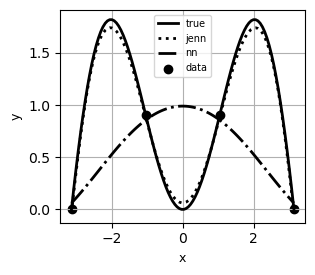

In [9]:
jenn.plot_sensitivity_profiles(
    func=[jenn.synthetic_data.sinusoid.compute, genn.predict, nn.predict], 
    x_min=x_train.min(), 
    x_max=x_train.max(), 
    x_true=x_train, 
    y_true=y_train, 
    resolution=100, 
    legend_label=['true', 'jenn', 'nn'], 
    xlabels=['x'], 
    ylabels=['y'],
    show_cursor=False
)

### Save / Reload Model

Model parameters are serialized. They can be easily saved as `json` and reloaded later. 

_Save old model_: 

In [10]:
old_model = genn
old_model.save('parameters.json')

_Reload old model_:

In [11]:
new_model = jenn.NeuralNet.load('parameters.json')

_Verify that old and new model agree_:

In [12]:
assert (new_model.predict(x_test) == old_model.predict(x_test)).all()